**W207_3 machine learning Final group Rossman competition Forecast sales using store, promotion, and competitor data**
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams!
If you are interested in joining Rossmann at their headquarters near Hanover, Germany, please contact Mr. Frank König (Frank.Koenig {at} rossmann.de) Rossmann is currently recruiting data scientists at senior and entry-level positions.
https://www.kaggle.com/c/rossmann-store-sales
Started: 12:02 pm, Wednesday 30 September 2015 UTC Ends: 11:59 pm, Monday 14 December 2015 UTC (75 total days) Points: this competition awards standard ranking points Tiers: this competition counts towards tiers


Issues page: https://github.com/MIDS-W207/2015_fall_coursework/issues

In [358]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.cm as cm

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.dates as dates
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

import datetime

import pandas as pd
from pandas import Series,DataFrame

import random
import numpy as np
import graphviz as gv
import csv
from scipy import sparse
import time

from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn import naive_bayes


In [359]:
###### functions #######

def MergeTheDfs (train_df, store_df):
    #For each store, find its first opening day and merge it into store_df
    train_by_Store_df = train_df.groupby('Store')
    storeOpenDays = train_by_Store_df['Date'].min()
    #pd.unique(storeOpenDays)
    #storeOpenDays[storeOpenDays != np.datetime64('2013-01-02')]

    d = pd.DataFrame(storeOpenDays)
    d = d.rename(columns = {'Date':'OpenDay'})
    store_df = pd.merge(store_df, d, left_on = 'Store', right_index = True) 
    
    #For each store, convert it's competitor open day into a Date column
    competitorOpenDay = store_df.apply(lambda row: np.nan 
            if pd.isnull(row['CompetitionOpenSinceMonth']) or pd.isnull(row['CompetitionOpenSinceYear'])
            else np.datetime64("%d-%02d-01" % (int(row['CompetitionOpenSinceYear']), int(row['CompetitionOpenSinceMonth']))), 
            axis=1)
    store_df["CompetitorOpenDay"] = competitorOpenDay

    # For those stores with empty CompetitorOpenDay date, set it to the same as StoreOpenDay
    store_df.ix[:, 'CompetitorOpenDay'] = store_df["CompetitorOpenDay"].fillna(store_df['OpenDay'])
    #store_df.ix[:,['CompetitorOpenDay', 'OpenDay']]

    # Merge store data into train data
    train_df = pd.merge(train_df, store_df, on="Store")

    #**I am adding this to use cumulative_days instead of date -GAK**
    # I think We can deal with cycles by using month
    # add cumulitive days open
    
    
    # Use Date as the index.  This will make exploration much easier.
    train_df = train_df.set_index('Date')
    return [train_df, store_df]

def quantLevel(df, ColNameLs=['Open', 'StateHoliday', 'SchoolHoliday', 'Promo']):
    # Display percentage of unique values of these fields
    for col in ColNameLs:
        sizes = df.groupby(col).size()
        print sizes / sizes.sum()
        print
    
def rmspe(y, yhat):
    y = y.astype('float')
    yhat = yhat.astype('float')
    inner = ((y-yhat)/y)**2
    return (np.mean(inner))**0.5


def convertColToCategory(data, colName, knownCategories):
    data.loc[:, colName] = data.loc[:, colName].astype('category', categories=knownCategories)

def transformData(inputData):
    data = inputData.copy()
    # StateHoliday have values of both '0' and 0.  Change all 0 to '0'
    data.loc[data['StateHoliday'] == 0, ('StateHoliday')] = '0'
    # Can consider:
    # Add a "IsDec" col
    # Convert categorical columns to category type
    convertColToCategory(data, 'DayOfWeek', list(range(1, 8)))
    convertColToCategory(data, 'Promo', list(range(2)))
    convertColToCategory(data, 'SchoolHoliday', list(range(2)))
    convertColToCategory(data, 'StateHoliday', list('0abc'))    
    
    if 'StoreType' in data.columns:
        convertColToCategory(data, 'StoreType', list('abcd'))
                         
    if 'Assortment' in data.columns:
        convertColToCategory(data, 'Assortment', list('abc'))

    return pd.get_dummies(data)


def trainModels(n_cutoff_months):
    all_y = []
    all_yhat = []
    lms = {}
    
    test_cutoff_date = train_data.index.max() - pd.DateOffset(months = n_cutoff_months)

    train_set = train_data[train_data.index <= test_cutoff_date]
    dev_set = train_data[train_data.index > test_cutoff_date]
    print "train_set size:", len(train_set)
    print "dev_set size:", len(dev_set)

    train_set_grouped = train_set.groupby('Store')
    dev_set_grouped = dev_set.groupby('Store')
    cols = None

    for group in train_set_grouped.groups.keys():
        x_drop_cols = ['Store', 'Sales', 'Customers', 'Open']

        train_X = train_set_grouped.get_group(group).drop(x_drop_cols, axis=1, inplace=False)
        train_y = train_set_grouped.get_group(group)['Sales']

        dev_X = dev_set_grouped.get_group(group).drop(x_drop_cols, axis=1, inplace=False)
        dev_y = dev_set_grouped.get_group(group)['Sales']

        # One model per store
        lm = linear_model.LinearRegression()
        lm.fit(X=train_X, y=train_y)
        lms[group] = lm
        yhat = lm.predict(dev_X)

        all_y.extend(dev_y.tolist())
        all_yhat.extend(yhat.tolist())
        
    print "Training model - dev data RMSPE=", RMSPE(np.array(all_y), np.array(all_yhat))
    return lms


def littleTest():
    # Test prediction using some input generated from training data
    random_idx = random.sample(train_df.index.tolist(), 100)

    try_df = train_df.loc[random_idx]
    try_y = try_df['Sales']
    try_df.drop(['Sales', 'Customers'], axis=1, inplace=True)
    try_df["Id"] = range(1, len(try_df) + 1)
    try_data = transformData(pd.merge(try_df, store_df.ix[:,['StoreType', 'Assortment', 'Store']], on='Store'))

    result = makePredictions(try_data)
    try_yhat = np.array([r[1] for r in result])

    print rmspe(try_y, try_yhat)
    
def BoxPlotGroupBy(data, y, group, axis):
    ax = sns.boxplot(data[y], groupby = data[group], 
                     order = np.sort(pd.unique(data[group])), ax = axis)
    txt = ax.set_title(y + " grouped by " + group) 
    if axis is None:
        plt.show()
        
        
def SalesSlopes(storeDt, trainDt):
    storeDt['Slope'] = np.empty(len(storeDt)) * np.nan
    ts = trainDt.sort_index()
    variables=['Customers','Sales']
    
    for i in range(1, len(ts['Store'].unique())):
        if i%100 == 0:
            print 'up to store number' + str(i) 
        ts1 = trainDt[trainDt.Store == i] 
        xd=ts1.Customers
        yd=ts1.Sales
        #
        #xd='ts1.' + variables[0]
        #yd='ts1.' + variables[1]
        par = np.polyfit(xd, yd, 1, full=True) # determine best fit line

        # add slope to store data
        slope=par[0][0]
        storeDt['Slope'][storeDt['Store'] == i]=slope
    return storeDt    


def TrendStats(plot_df):
    ## ADD A BEST FIT LINE from - http://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
    xd=plot_df.Customers
    yd=plot_df.Sales
    par = np.polyfit(xd, yd, 1, full=True) # determine best fit line

    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]

    # coefficient of determination, plot text
    variance = np.var(yd)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    plt.text(Xbound/15,Ybound*.85,'$R^2 = %0.2f$'% Rsqr, fontsize=15)
    plt.text(Xbound/15,Ybound*.7,'$m = %0.2f$'% slope, fontsize=15)
    plt.plot(xl, yl, '-r')

def PlotAvgSalesByGroup(group, storeId=None, dim=None, daily=False, marker='o', alpha=0.7, **kwargs):
    stores = [None]
    if type(storeId) is list:
        stores = storeId
    else:
        stores = [storeId]
        
    if dim is None:
        dim = [1, len(stores)]
        
    fig, axises = plt.subplots(dim[0], dim[1], figsize=(15,3 * dim[0]))
    if len(stores) == 1:
        axises = [axises]
    else:
        axises = axises.ravel()

    for store, axis in zip(stores, axises):
        if store is None:
            df = train_data2
            title = None
        else:
            df = train_data2[train_data2['Store'] == store]
            title = 'Store ' + str(store)

        train_df_by_group = df.groupby(group)
        colors = cm.rainbow(np.linspace(0, 1, len(train_df_by_group)))
        labels = []

        if not daily:
            monthly_data = train_df_by_group.resample('M', how='mean')

            for groupItem, c in zip(train_df_by_group.groups.keys(), colors):
                # Note: Here we use .loc instead of .ix, otherwise will have problem if groupItem is an integer, as
                #       df.ix[[0]] will give you the first row instead of the first level of a multi-index df
                ax = monthly_data.loc[[groupItem]].plot(y='Sales', ax=axis, marker=marker,
                         legend=False, label=None, color=c, rot=0, alpha=alpha, **kwargs)

                labels.append(str(group) + " = " + str(groupItem))

            dateRange = pd.date_range(train_data2.index.min(), train_data2.index.max(), freq='M')
            axis.set_xticks(range(len(dateRange)))
            axis.set_xticklabels(["%d-%02d" % (x.year, x.month) for x in dateRange], rotation=90)
        else:
            for groupItem, c in zip(train_df_by_group.groups.keys(), colors):
                d = train_df_by_group.get_group(groupItem).sort_index()
                ax = axis.plot_date(x=d.index.tolist(), y=d['Sales'].tolist(), color=c, marker=marker, 
                                    alpha=alpha, **kwargs)
                labels.append(str(group) + " = " + str(groupItem))

            axis.xaxis.set_major_locator(MonthLocator(range(1, 13), bymonthday=1, interval=1))
            axis.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            fig.autofmt_xdate(rotation=90)
            plt.grid(True)

        axis.legend(labels, loc = 2, numpoints = 1)
        if title is not None:
            axis.set_title(title)   
            
            
                 
def getDayDiff(data, start, end):
    idxLs=range(len(data))
    df = pd.DataFrame(np.nan, index=idxLs, columns=['CumlDays'])
    #DayDiff = test_data2.index-test_data2.OpenDay
    DayDiff = end-start
    for i in range(len(DayDiff)):
        if i%1000==0:  # print output every 1000  
            print 'before assign ' + str(DayDiff[i])
            #print df
        df['CumlDays'][i]=int(str(DayDiff[i]).split(' ')[0])
        if i%1000==0:  # print output every 1000  
            #str(CumlDays[i]).split(' ')[0]
            print 'After assign ' + str(df['CumlDays'][i])
    #data=data + df['CumlDays']  
    #print data
    return data



## data wrangle

In [360]:
train_data = pd.read_csv('train.csv') #~/Development/kaggle/rossman/data/
test_data = pd.read_csv('test.csv') #~/Development/kaggle/rossman/data/
store_data = pd.read_csv('store.csv') #~/Development/kaggle/rossman/data/

In [361]:
# Fixing column 7 errors it by change all 0 to '0'
train_data.loc[train_data['StateHoliday'] == 0, 'StateHoliday'] = '0'

# Convert the date column in train and test data
train_data['Date'] = pd.to_datetime(train_data['Date'], format="%Y-%m-%d")
test_data['Date'] = pd.to_datetime(test_data['Date'], format="%Y-%m-%d")

###Closed Stores####
# Closed stores are dont sell anything. Closed stores comprise ~15% of the test set. 
# According to the board closed store predictions do not count toward the score.

#> closed=train_data[train_data['Open']==0]
#> quantLevel(closed, ['Sales'])
#> quantLevel(test_data, ['Open'])

#Keep only records where the store is open
train_data = train_data.loc[train_data['Open'] == 1]
test_data = test_data.loc[test_data['Open'] == 1]


# Keep only records with non-zero sales
train_data = train_data.loc[train_data['Sales'] > 0]
train_data = train_data.loc[train_data['Sales'] > 0]

# remove open since it is not used
test_data.drop('Open', axis=1, inplace='true')
train_data.drop('Open', axis=1, inplace='true')

#add a month column
train_data['month']=train_data['Date'].dt.month
test_data['month']=test_data['Date'].dt.month



In [362]:
data=MergeTheDfs (train_data, store_data)
train_data2=data[0]
store_data2=data[1]

data=MergeTheDfs (test_data, store_data)
test_data2=data[0]



print train_data.columns
print store_data.columns

print train_data.head(2)
print store_data.head(2)

print train_data2.columns
print store_data2.columns

print train_data2.head(2)
print store_data2.head(2)

#Add a cumulative days open column
#TO DO fix getDayDiff to produce an integer date diff
#test_data2['CumlDays']=CumlDays
#test_data2=getDayDiff(test_data2, test_data2.OpenDay, test_data2.index) 

train_data2['CumlDays'] = train_data2.index-train_data2.OpenDay

# fill in NaNs - this is erasing the arrays for some reason
train_data2.fillna(0, inplace=True)
test_data2.fillna(0, inplace=True)

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Promo',
       u'StateHoliday', u'SchoolHoliday', u'month'],
      dtype='object')
Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval'],
      dtype='object')
   Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555      1            0   
1      2          5 2015-07-31   6064        625      1            0   

   SchoolHoliday  month  
0              1      7  
1              1      7  
   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a                 1270                          9   
1      2         a          a                  570                         11   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0   

## 1- Feature exploration and enginering 
Add suggested features with justification

## some of these stores do much better than others ##
* that is evident from differences in the slope of the lines for this sample set
I think we should include slope of historical customer x sales relation when making predictions * 


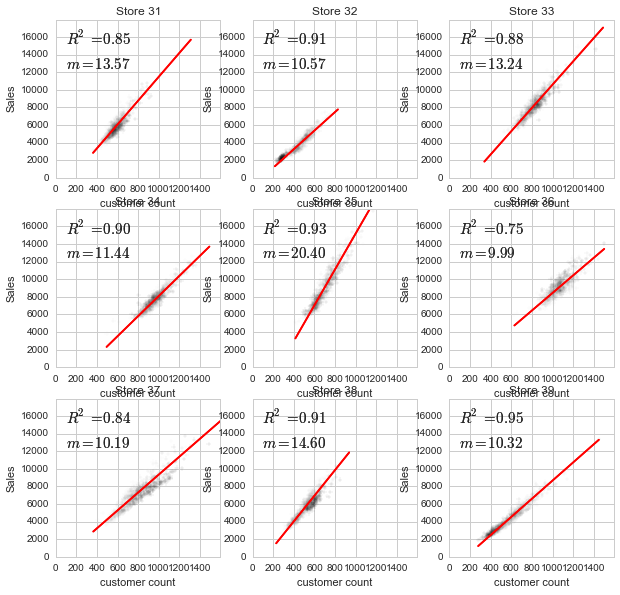

In [363]:
ts = train_data2.sort_index() # sort by date 
#store_df = train_data.loc[train_data['Store'] == store]
num_plots = 9
plt.figure(figsize=(10,num_plots*10/3))

starting_store = 31
# set uniform axis so most stores fit in 
Xbound=np.percentile(ts.Customers, 95)
Ybound=np.percentile(ts.Sales, 99)

for i in range(0, num_plots):
    plot_df = ts.loc[ts['Store'] == i + starting_store]
    #plot_df = ts1[ts1['Sales'] > 500]
    colors = plot_df.DayOfWeek
    plt.subplot(num_plots, 3, i + 1)
    #plt.axis('off')
    plt.title('Store {0}'.format(starting_store + i))
    plt.scatter(plot_df.Customers, plot_df.Sales, s=20, marker= "+", c=colors, alpha=.25)
    # I am not sure why I have lost the ability to control marker size/ color above
    plt.axis([0, Xbound+150, 0, Ybound+150]) 

    plt.ylabel('Sales')
    plt.xlabel('customer count')
    
    ## ADD A BEST FIT LINE from - http://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
    xd=plot_df.Customers
    yd=plot_df.Sales
    par = np.polyfit(xd, yd, 1, full=True) # determine best fit line

    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]

    # coefficient of determination, plot text
    variance = np.var(yd)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    plt.text(Xbound/15,Ybound*.85,'$R^2 = %0.2f$'% Rsqr, fontsize=15)
    plt.text(Xbound/15,Ybound*.7,'$m = %0.2f$'% slope, fontsize=15)
    plt.plot(xl, yl, '-r')
    
    TrendStats(plot_df)
    
plt.show()

## add a legend with weekday ##
## scatterplot of sales by day of week## group by store type

# There are store-typical difference in sales/ customer
# Customer volume is  highly predicive of sales#
* ~.9 R squared and seems relatively stable over time for each store on each day of the week. *

I think we should include the:
historical customer volume x store and 
historical customer volume x day of week
when making predictions.

#Augment store dataframe with UNIT CUSTOMER SALES(slope of CUSTOMER X SALES)
## slope of a best fit line from 
http://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

In [364]:
# add sales per customer (slope) feature to the stores frame

store_data2=SalesSlopes(store_data2, train_data2)

print 'Sanity check, compare graphs to batch analysis'  
print 'expect slope = 11.40, computed slope: ' + str(store_data2[store_data2.Store == 34]['Slope']) 
print 'expect slope = 20.44, computed slope: ' + str(store_data2[store_data2.Store == 35]['Slope'] )
print 'expect slope = 9.99, computed slope: ' + str(store_data2[store_data2.Store == 36]['Slope'] )

# More sanity check if needed
#>>store_data=SalesSlopes(store_data, train_data)

#>>print 'Sanity check, compare graphs to batch analysis'  
#>>print 'expect slope = 11.40, computed slope: ' + str(store_data[store_data.Store == 34]['Slope']) 
#>>print 'expect slope = 20.44, computed slope: ' + str(store_data[store_data.Store == 35]['Slope'] )
#>>print 'expect slope = 9.99, computed slope: ' + str(store_data[store_data.Store == 36]['Slope'] )

up to store number100
up to store number200
up to store number300
up to store number400
up to store number500
up to store number600
up to store number700
up to store number800
up to store number900
up to store number1000
up to store number1100
Sanity check, compare graphs to batch analysis
expect slope = 11.40, computed slope: 33    11.439174
Name: Slope, dtype: float64
expect slope = 20.44, computed slope: 34    20.396674
Name: Slope, dtype: float64
expect slope = 9.99, computed slope: 35    9.99257
Name: Slope, dtype: float64


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


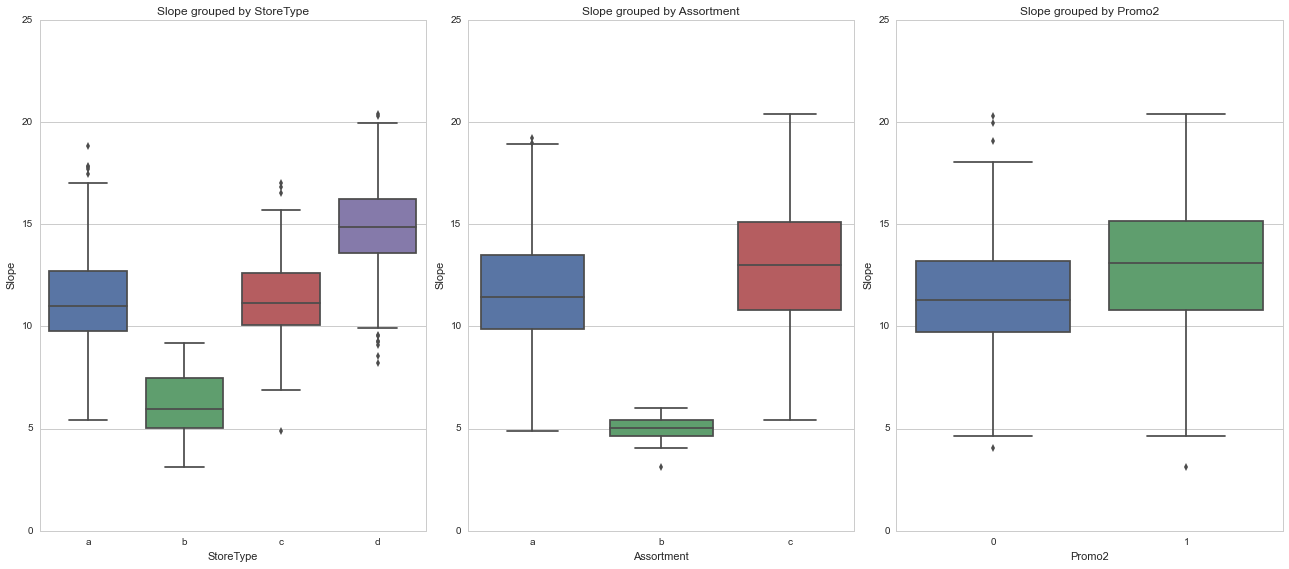

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 21 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null object
SchoolHoliday                844338 non-null int64
month                        844338 non-null int64
StoreType                    844338 non-null object
Assortment                   844338 non-null object
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenSinceYear     844338 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              844338 non-null float64
Promo2SinceYear              844338 non-null float64
PromoInterval                844338 non-null object
OpenDay 

In [365]:
#INSPECT THE SLOPE DATA

# do store sales per customer correspond to 
#store type, 
#Competition distance, 
#assortment, 
#comptetion open since month

##NEW FEATURE
fig, ax_list = plt.subplots(1,3, figsize=(18,8))
ax_list = ax_list.ravel()

BoxPlotGroupBy(store_data2,'Slope', 'StoreType', ax_list[0])
BoxPlotGroupBy(store_data2,'Slope', 'Assortment', ax_list[1])
BoxPlotGroupBy(store_data2,'Slope', 'Promo2', ax_list[2])
fig.tight_layout()
plt.show()

# merge the new feature
SubSet=store_data2[['Store', 'Slope']]
test_data2=pd.merge(test_data2, SubSet, on='Store')
train_data2=pd.merge(train_data2, SubSet, on='Store')

train_data2.info()
test_data2.info()



#def BoxPlotGroupBy(data, y, group, axis):
#    ax = sns.boxplot(data[y], groupby = data[group], 
#                     order = np.sort(pd.unique(data[group])), ax = axis)
#    txt = ax.set_title(y + " grouped by " + group) 
#    if axis is None:
#        plt.show()

In [366]:
test_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 35092
Data columns (total 19 columns):
Id                           35093 non-null int64
Store                        35093 non-null int64
DayOfWeek                    35093 non-null int64
Promo                        35093 non-null int64
StateHoliday                 35093 non-null object
SchoolHoliday                35093 non-null int64
month                        35093 non-null int64
StoreType                    35093 non-null object
Assortment                   35093 non-null object
CompetitionDistance          35093 non-null float64
CompetitionOpenSinceMonth    35093 non-null float64
CompetitionOpenSinceYear     35093 non-null float64
Promo2                       35093 non-null int64
Promo2SinceWeek              35093 non-null float64
Promo2SinceYear              35093 non-null float64
PromoInterval                35093 non-null object
OpenDay                      35093 non-null datetime64[ns]
CompetitorOpenDay 

# How do assortment and store type co-segregate?
- make a nwe variable store efficiency (StoreEff) to account for differences in efficiency in conversion of customers to sales.

['ca' 'aa' 'cc' 'ac' 'da' 'dc' 'ba' 'bb' 'bc']
(array([ nan,  nan]), array([ nan]), 2, array([ 1.40990393,  0.11032186]), 2.4757973449140991e-13)
We do not get estimates from this regression model - is this because of heterogenity of variance?


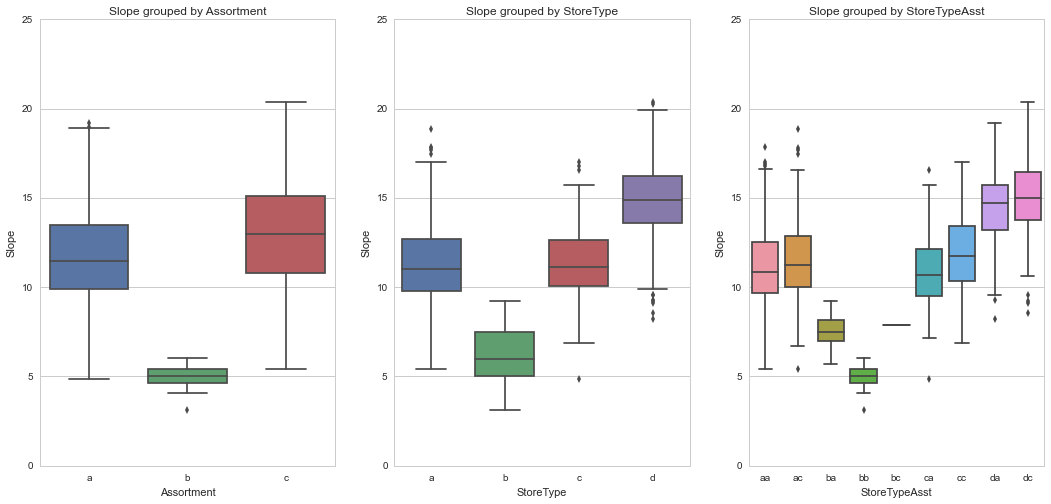

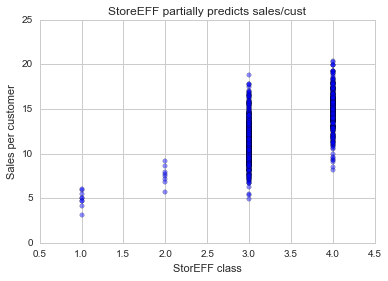

In [367]:
# combine store and assortment data into sales per customer (efficiency bins)
store_data2['StoreTypeAsst']=store_data2['StoreType'] + store_data2['Assortment']
print store_data2['StoreTypeAsst'].unique()

fig, ax_list = plt.subplots(1,3, figsize=(18,8))
ax_list = ax_list.ravel()

BoxPlotGroupBy(store_data2,'Slope', 'Assortment', ax_list[0])
BoxPlotGroupBy(store_data2,'Slope', 'StoreType', ax_list[1])
BoxPlotGroupBy(store_data2,'Slope', 'StoreTypeAsst', ax_list[2])

# make a new contnuous variable "Sales Efficiency" (storeEff) 
# binning stores by how effective each store is at selling 
# bb < ba, bc < aa, ac, ca, cc
transform={'bb':1,'ba':2,'bc':2, 'aa':3, 'ca':3, 'ac':3,  'cc':3, 'da':4,'dc':4}
eff=store_data2.StoreTypeAsst
eff = [transform[eff[i]] for i in range(len(eff))]
store_data2['storeEff']=eff

#NEW FEATURE merge in the new features
SubS_St=store_data2[['Store', 'StoreTypeAsst',  'storeEff']]
train_data2=pd.merge(train_data2, SubS_St, on='Store', how='inner')
test_data2=pd.merge(test_data2, SubS_St, on='Store', how='inner')


plt.figure()
plt.scatter(store_data2.storeEff, store_data2.Slope, marker="o", alpha=.45)
plt.title ("StoreEFF partially predicts sales/cust")
plt.xlabel('StorEFF class')
plt.ylabel('Sales per customer')

## ADD A BEST FIT LINE from - http://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
xd=store_data2.storeEff
yd=store_data2.Slope
par = np.polyfit(xd, yd, 1, full=True) # determine best fit line

slope=par[0][0]
intercept=par[0][1]
xl = [min(xd), max(xd)]
yl = [slope*xx + intercept  for xx in xl]

# coefficient of determination, plot text
variance = np.var(yd)
residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
Rsqr = np.round(1-residuals/variance, decimals=2)
print par  # we do have heterogenity of variance here
print 'We do not get estimates from this regression model - is this because of heterogenity of variance?'


# Assortment and store type are key features that affect sales, Why?


# does competition distance affect unit sales/cust? 
# Is there an interaction with store type?

 - There may be a competion effect for type b 

 - Not really much here
 
 - I will adjust (AdjDist) the distance so that it is inverted (further gets less weight)
 
 - And so that it zeros out at some threshold (after 5000)

In [470]:
#train_data2 = train_data2.drop('AdjDist_x', 1)
train_data2 = train_data2.drop('AdjDist', 1)
train_data2.columns

#test_data2 = test_data2.drop('AdjDist_x', 1)
test_data2 = test_data2.drop('AdjDist', 1)
test_data2.columns

Index([u'Id', u'Store', u'DayOfWeek', u'Promo', u'StateHoliday',
       u'SchoolHoliday', u'month', u'StoreType', u'Assortment',
       u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval', u'OpenDay', u'CompetitorOpenDay',
       u'Slope', u'StoreTypeAsst', u'storeEff', u'MonthBin'],
      dtype='object')

70860.0
75860.0


count    844338.000000
mean      70415.974598
std        7804.387332
min           0.000000
25%       68980.000000
50%       73540.000000
75%       75160.000000
max       75860.000000
Name: AdjDist, dtype: float64

In [449]:
train_data2.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,month,StoreType,Assortment,...,OpenDay,CompetitorOpenDay,CumlDays,Slope,StoreTypeAsst,storeEff,SalePerCust,MonthBin,log1pSales,AdjDist
0,1,5,5263,555,1,0,1,7,c,a,...,2013-01-02,2008-09-01,940 days,10.081856,ca,3,9.482883,2,8.568646,3730
1,1,4,5020,546,1,0,1,7,c,a,...,2013-01-02,2008-09-01,939 days,10.081856,ca,3,9.194139,2,8.521384,3730
2,1,3,4782,523,1,0,1,7,c,a,...,2013-01-02,2008-09-01,938 days,10.081856,ca,3,9.143403,2,8.472823,3730
3,1,2,5011,560,1,0,1,7,c,a,...,2013-01-02,2008-09-01,937 days,10.081856,ca,3,8.948214,2,8.519590,3730
4,1,1,6102,612,1,0,1,7,c,a,...,2013-01-02,2008-09-01,936 days,10.081856,ca,3,9.970588,2,8.716536,3730


it does appear that store distance becomes irrelevant at a certain point (5000) - this shows a more of a trend
make a new feature to reflect the heterogenious effect of distance


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


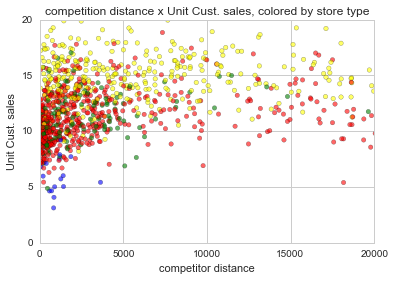

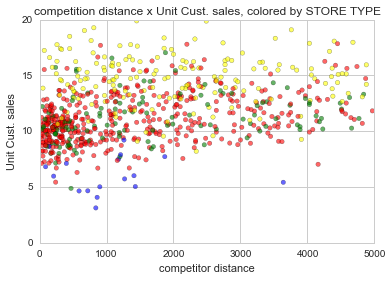

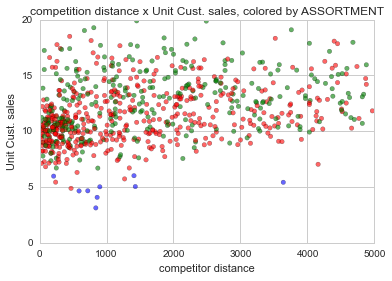

In [471]:
plt.figure()
y=store_data2.Slope
x=store_data2.CompetitionDistance

#recode strings as colors
transform = {"a": 'red', "b": 'blue', "c": 'green', "d": 'yellow'}
colors=store_data2.StoreType
colors = [transform[colors[i]] for i in range(len(colors))]

# TO DO: look a little deeper at the store type X dist interaction
# plot best fit lines; b type (blue) might be susceptable to competition
plt.title('competition distance x Unit Cust. sales, colored by store type')
plt.xlabel('competitor distance')
plt.ylabel('Unit Cust. sales')
plt.axis([0,20000, 0, 20])
plt.scatter(x,y, c=colors, marker="o", alpha=.6)

#(plot_df.Customers, plot_df.Sales, s=20, marker= "+", c=colors, alpha=.25)


print 'it does appear that store distance becomes irrelevant at a certain point (5000) - this shows a more of a trend'


def TrendStats(plot_df, lineC):
    ## ADD A BEST FIT LINE from - http://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
    plot_df.head()
    xd=plot_df.CompetitionDistance
    yd=plot_df.Slope
    par = np.polyfit(xd, yd, 1, full=True) # determine best fit line

    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]

    # coefficient of determination, plot text
    variance = np.var(yd)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    plt.text(Xbound/15,Ybound*.85,'$R^2 = %0.2f$'% Rsqr, fontsize=15)
    plt.text(Xbound/15,Ybound*.7,'$m = %0.2f$'% slope, fontsize=15)
    plt.plot(xl, yl, lineC)


DistTH=5000
plt.figure()
subset=store_data2[store_data2.CompetitionDistance < DistTH]
subset=subset.reset_index()
y=subset.Slope
x=subset.CompetitionDistance

#recode strings as colors
transform = {"a": 'red', "b": 'blue', "c": 'green', "d": 'yellow'}
colors=subset.StoreType
colors = [transform[colors[i]] for i in range(len(colors))]

# TO DO: look a little deeper at the store type X dist interaction
# plot best fit lines; b type (blue) might be susceptable to competition
plt.title('competition distance x Unit Cust. sales, colored by STORE TYPE')
plt.xlabel('competitor distance')
plt.ylabel('Unit Cust. sales')
plt.axis([0,DistTH, 0, 20])


## TO DO: fix this to plot trend lines
#SubA=subset[subset.StoreType == 'a'].reset_index()
#print type(SubA)
#print SubA['CompetitionDistance']
#TrendStats(SubA, 'r-')

plt.scatter(x,y, c=colors, marker="o", alpha=.6)

#(plot_df.Customers, plot_df.Sales, s=20, marker= "+", c=colors, alpha=.25)

## FIX THIS teh values are too large..

## fixed version does not work as well
def AdjDistFIX(data, distTH):
    #Zero out distances further than the threshold
    #[data[x]['AdjDist']= 0, for x in train_data2 if train_data2.CompetitionDistance[X] > (MaxDist-distTH)]
    
    #reverse the distance (max becomes 0, min becomes max)
    MaxDist=np.max(data.CompetitionDistance)
    data['AdjDist']=np.max(data.CompetitionDistance)-data.CompetitionDistance
    for x in range(len(data)):   
        if data.AdjDist[x] < (np.max(data.CompetitionDistance)-distTH):
            #print data.CompetitionDistance[x]
            #print distTH
            #print data.CompetitionDistance[x] > distTH
            data.AdjDist[x] = 0 
    #subtract the threshold distance from the baseline
    ##>> this seems to make predictions worse
    ##>>data['AdjDist']=data.AdjDist-(np.max(data.CompetitionDistance)-distTH)
    return data  

##OLD,better 
def AdjDist(data, distTH):
    #reverse the distance (max becomes 0, min becomes max)
    MaxDist=np.max(data.CompetitionDistance)
    data['AdjDist']=np.max(data.CompetitionDistance)-data.CompetitionDistance
    
    #Zero out distances further than the threshold
     #[data[x]['AdjDist']= 0, for x in train_data2 if train_data2.CompetitionDistance[X] > (MaxDist-distTH)]
    for x in range(len(data)):
        if data.CompetitionDistance[x] > distTH:
            #print data.CompetitionDistance[x]
            #print distTH
            #print data.CompetitionDistance[x] > distTH
            data.AdjDist[x] = 0 
    data        
    return data 

print 'make a new feature to reflect the heterogenious effect of distance'

#NEW FEATURE
distTH=5000 
store_data2=AdjDist(store_data2, distTH) 

#NEW FEATURE merge in the new features
SubS_St=store_data2[['Store', 'AdjDist']]
train_data2=pd.merge(train_data2, SubS_St, on='Store', how='inner')
test_data2=pd.merge(test_data2, SubS_St, on='Store', how='inner')

#Merge the 
#test2=AdjDist(train_data2, distTH) 

plt.figure()

# at a certain disance the competitor is too far
distTH=5000

subset2=store_data2[store_data2.CompetitionDistance < distTH]
subset2=subset2.reset_index()
y=subset2.Slope
x=subset2.CompetitionDistance

#recode strings as colors
transform = {"a": 'red', "b": 'blue', "c": 'green', "d": 'yellow'}
colors=subset2.Assortment
colors = [transform[colors[i]] for i in range(len(colors))]
plt.title('competition distance x Unit Cust. sales, colored by ASSORTMENT')
plt.xlabel('competitor distance')
plt.ylabel('Unit Cust. sales')
plt.axis([0, distTH, 0, 20])
plt.scatter(x,y, c=colors, marker="o", alpha=.6)

#(plot_df.Customers, plot_df.Sales, s=20, marker= "+", c=colors, alpha=.25)

In [472]:
test_data2.head()

,Id,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,month,StoreType,Assortment,CompetitionDistance,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,OpenDay,CompetitorOpenDay,Slope,StoreTypeAsst,storeEff,MonthBin,AdjDist
0,1,1,4,1,0,0,9,c,a,1270,...,0,0,0,2015-08-01,2008-09-01,10.081856,ca,3,2,74590
1,857,1,3,1,0,0,9,c,a,1270,...,0,0,0,2015-08-01,2008-09-01,10.081856,ca,3,2,74590
2,1713,1,2,1,0,0,9,c,a,1270,...,0,0,0,2015-08-01,2008-09-01,10.081856,ca,3,2,74590
3,2569,1,1,1,0,0,9,c,a,1270,...,0,0,0,2015-08-01,2008-09-01,10.081856,ca,3,2,74590
4,4281,1,6,0,0,0,9,c,a,1270,...,0,0,0,2015-08-01,2008-09-01,10.081856,ca,3,2,74590




There is heterogenity of variance


mean eff class 1: 4.8815820136
mean eff class 2: 7.57254386248
mean eff class 3: 11.282487591
mean eff class 4: 14.8826868831
var eff class 1: 0.738099666153
var eff class 2: 1.01558143774
var eff class 3: 4.68858555799
var eff class 4: 4.64742415188


at a certain distance the competitor is too far to affect sales
lets look at stores with distant competition


mean eff class 3: 11.8763585819
mean eff class 4: 14.8679502644
var eff class 1: nan
var eff class 2: nan
var eff class 3: 5.20967224594
var eff class 4: 4.09711706666


lets look just for stores with close competitiors


mean eff class 1: 4.8815820136
mean eff class 2: 7.57254386248
mean eff class 3: 11.0556716445
mean eff class 4: 14.7172661054
var eff class 1: 0.738099666153
var eff class 2: 1.01558143774
var eff class 3: 4.32472874323
var eff class 4: 5.29836057277


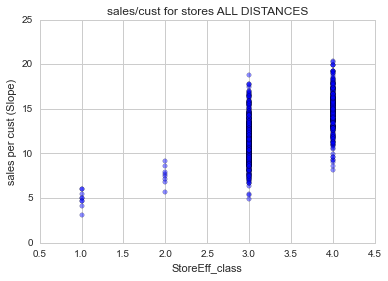

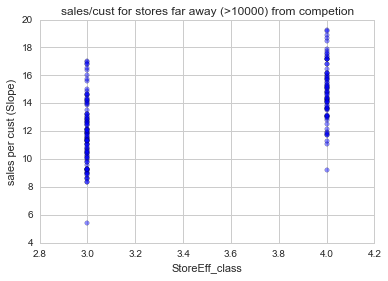

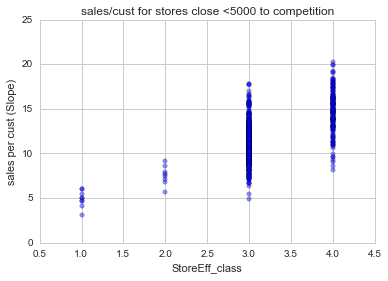

In [369]:
# at a certain distance the competitor is too far to affect sales
# lets look just for stores with competion to see if the large variance across store effclasses 
# are predicted by distance to competition 

distTH=60000 #all the data

subset3=store_data2[store_data2.CompetitionDistance < distTH] 
subset3=subset3.reset_index()

print '\n'
print 'There is heterogenity of variance'
print '\n'


print 'mean eff class 1: ' + str(np.mean(subset3[subset3.storeEff==1].Slope))
print 'mean eff class 2: ' + str(np.mean(subset3[subset3.storeEff==2].Slope))
print 'mean eff class 3: ' + str(np.mean(subset3[subset3.storeEff==3].Slope))
print 'mean eff class 4: ' + str(np.mean(subset3[subset3.storeEff==4].Slope))

print 'var eff class 1: ' + str(np.var(subset3[subset3.storeEff==1].Slope))
print 'var eff class 2: ' + str(np.var(subset3[subset3.storeEff==2].Slope))
print 'var eff class 3: ' + str(np.var(subset3[subset3.storeEff==3].Slope))
print 'var eff class 4: ' + str(np.var(subset3[subset3.storeEff==4].Slope))


plt.figure()
plt.scatter(subset3.storeEff, subset3.Slope, marker="o", alpha=.45)
plt.title ('sales/cust for stores ALL DISTANCES')
plt.xlabel('StoreEff_class')
plt.ylabel('sales per cust (Slope)')

print '\n'
print 'at a certain distance the competitor is too far to affect sales'
print 'lets look at stores with distant competition'
print '\n'

distTH=10000

subset3=store_data2[store_data2.CompetitionDistance > distTH]
subset3=subset3.reset_index()

print 'mean eff class 3: ' + str(np.mean(subset3[subset3.storeEff==3].Slope))
print 'mean eff class 4: ' + str(np.mean(subset3[subset3.storeEff==4].Slope))

print 'var eff class 1: ' + str(np.var(subset3[subset3.storeEff==1].Slope))
print 'var eff class 2: ' + str(np.var(subset3[subset3.storeEff==2].Slope))
print 'var eff class 3: ' + str(np.var(subset3[subset3.storeEff==3].Slope))
print 'var eff class 4: ' + str(np.var(subset3[subset3.storeEff==4].Slope))

plt.figure()
plt.scatter(subset3.storeEff, subset3.Slope, marker="o", alpha=.45)
plt.title ("sales/cust for stores far away (>10000) from competion")
plt.xlabel('StoreEff_class')
plt.ylabel('sales per cust (Slope)')

print '\n'
print 'lets look just for stores with close competitiors'
print '\n'

distTH=5000

subset3=store_data2[store_data2.CompetitionDistance < distTH] 
subset3=subset3.reset_index()

print 'mean eff class 1: ' + str(np.mean(subset3[subset3.storeEff==1].Slope))
print 'mean eff class 2: ' + str(np.mean(subset3[subset3.storeEff==2].Slope))
print 'mean eff class 3: ' + str(np.mean(subset3[subset3.storeEff==3].Slope))
print 'mean eff class 4: ' + str(np.mean(subset3[subset3.storeEff==4].Slope))

print 'var eff class 1: ' + str(np.var(subset3[subset3.storeEff==1].Slope))
print 'var eff class 2: ' + str(np.var(subset3[subset3.storeEff==2].Slope))
print 'var eff class 3: ' + str(np.var(subset3[subset3.storeEff==3].Slope))
print 'var eff class 4: ' + str(np.var(subset3[subset3.storeEff==4].Slope))


plt.figure()
plt.scatter(subset3.storeEff, subset3.Slope, marker="o", alpha=.45)
plt.title ("sales/cust for stores close <5000 to competition")
plt.xlabel('StoreEff_class')
plt.ylabel('sales per cust (Slope)')

#I dont see any compelling reason to think that competition is contributing to the variance with in storeEff class

In [140]:
train_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 23 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null object
SchoolHoliday                844338 non-null int64
month                        844338 non-null int64
StoreType                    844338 non-null object
Assortment                   844338 non-null object
CompetitionDistance          842152 non-null float64
CompetitionOpenSinceMonth    575738 non-null float64
CompetitionOpenSinceYear     575738 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              421046 non-null float64
Promo2SinceYear              421046 non-null float64
PromoInterval                421046 non-null object
OpenDay 

In [141]:
test_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 35092
Data columns (total 22 columns):
Id                           35093 non-null int64
Store                        35093 non-null int64
DayOfWeek                    35093 non-null int64
Promo                        35093 non-null int64
StateHoliday                 35093 non-null object
SchoolHoliday                35093 non-null int64
month                        35093 non-null int64
StoreType                    35093 non-null object
Assortment                   35093 non-null object
CompetitionDistance          35028 non-null float64
CompetitionOpenSinceMonth    22090 non-null float64
CompetitionOpenSinceYear     22090 non-null float64
Promo2                       35093 non-null int64
Promo2SinceWeek              20290 non-null float64
Promo2SinceYear              20290 non-null float64
PromoInterval                20290 non-null object
OpenDay                      35093 non-null datetime64[ns]
CompetitorOpenDay 

In [ ]:
#next integrate store-specific customer traffic index

#Since there is non-overlap between days, use 
#cumulative days and SVM to make a daily traffic prediction for each store

#mean cust traffic per day x day pattern x day contribution

#check storeEFF per day....

#How do variables affect sales in general?

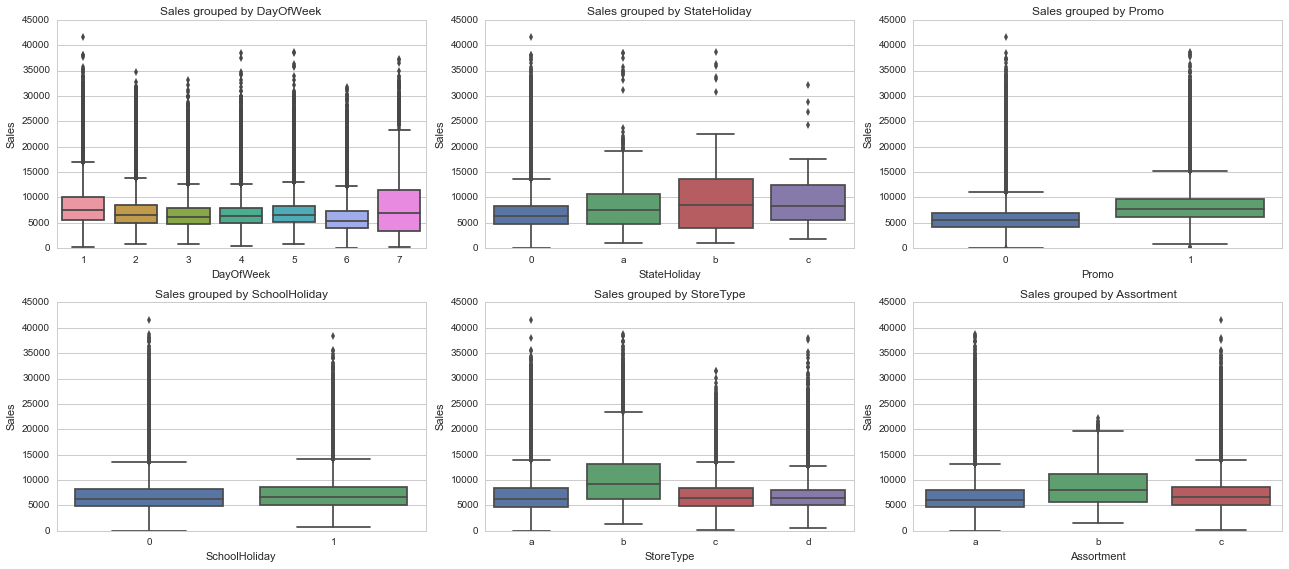

In [46]:
fig, ax_list = plt.subplots(2,3, figsize=(18,8))
ax_list = ax_list.ravel()

BoxPlotGroupBy(train_data2, 'Sales', 'DayOfWeek', ax_list[0])
BoxPlotGroupBy(train_data2,'Sales', 'StateHoliday', ax_list[1])
BoxPlotGroupBy(train_data2,'Sales', 'Promo', ax_list[2])
BoxPlotGroupBy(train_data2,'Sales', 'SchoolHoliday', ax_list[3])
BoxPlotGroupBy(train_data2,'Sales', 'StoreType', ax_list[4])
BoxPlotGroupBy(train_data2,'Sales', 'Assortment', ax_list[5])
fig.tight_layout()

plt.show()

CUSTOMER NUMBER rather than customer unit sales appears
to be contributing most to the positively skewed tail.


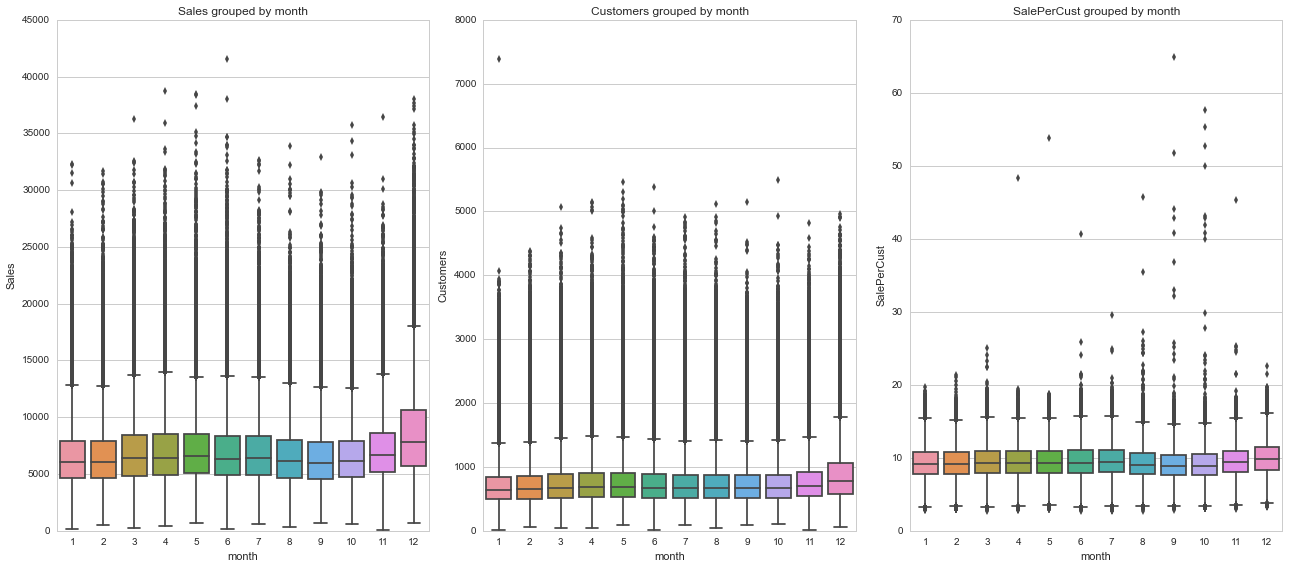

In [370]:
## TO DO  -  PREDICTED DAILY Sales. cust look to customer number, and sales per customer
##... TIME SERIES PREDICTION

## there are so many outliers on the upper end that they are obscuring the differences
## look at the month panel,

# looking at averages it looks like there is a strong month effect on sales 

# however these distributions are really positively skewed indicating that 
# there is a lot of influnetial data not captured by the mean 

print 'CUSTOMER NUMBER rather than customer unit sales appears' 
print 'to be contributing most to the positively skewed tail.'

# NEW FEATURE add the new customer centric variables
# this is like the storeEff but is broken down for every training measurement
train_data2['SalePerCust']=train_data2.Sales/train_data2.Customers



####### note no sales data for the training data 
####### since the days dont fully overlap this will have to be predicted then applied
####### test_data2['SalePerCust']=test_data2.Sales/test_data2.Customers


fig, ax_list = plt.subplots(1,3, figsize=(18,8))
ax_list = ax_list.ravel()
BoxPlotGroupBy(train_data2, 'Sales', 'month', ax_list[0])
BoxPlotGroupBy(train_data2, 'Customers', 'month', ax_list[1])
BoxPlotGroupBy(train_data2, 'SalePerCust', 'month', ax_list[2])
fig.tight_layout()
plt.show()
#color = ('b','g','r')
#for i,col in enumerate(color):
    #histr = cv2.calcHist(np.log(train_data2.Sales), train_data2.month)
#    plt.hist
    
    
#plt.hist(uniform_numbers, bins=20, histtype='stepfilled', normed=True, color='r', alpha=0.5, label='Uniform')
#plt.xlabel("Value")
#plt.ylabel("Probability")
#plt.legend()
#plt.show()
    #plt.xlim([0,256])
#plt.show()

#print this as a histogram to see where the data falls
#FIx:  plotting htese separately fails
#>MonthLs=train_data2.month.unique()
#>for i in range(len(MonthLs)):
    #>print MonthLs[i]
      #>dataSub=(train_data2[train_data2.month == MonthLs[i]].Sales)
      #>plt.hist(dataSub, bins=50, color='k', normed=True, alpha=.5, histtype='stepfilled', label=str(MonthLs[i]))
#>plt.title('sales per month')
#>plt.xlabel("Value")
#>plt.ylabel("Probability")
#>plt.legend()
#>plt.show()

month
1     6564.298651
2     6589.494012
3     6976.817749
4     7046.659509
5     7106.808038
6     7001.402127
7     6953.575827
8     6649.229053
9     6547.469104
10    6602.967255
11    7188.554250
12    8608.956661
Name: Sales, dtype: float64
note the heterogenity of variance that is captured by monthbin for sales/customer
it appears that somthing is increase noise in sales/customer in bin 1 months


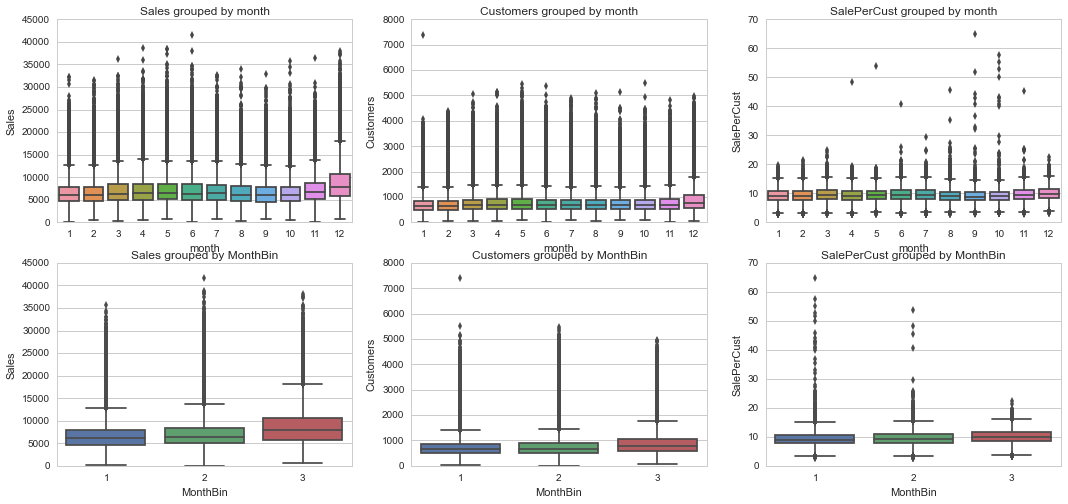

In [408]:
# The sales data per month appears to be constant except in a few key months. 
# the new feature ('MonthBin') in meant to reduce the month levels to a few bins
# also adding Logsales


import scipy.stats as ss

TnMonth=train_data2.groupby('month')
print TnMonth['Sales'].mean()

#print TnMonth['Sales'].variation()


# I am going to bin months in an ordinal variable MonthBin


#BIN 1: range 6564-6649 
#1     6564.298651
#9     6547.469104
#2     6589.494012
#8     6649.229053
#10    6602.967255

#BIN 2: range 6953-7188
#3     6976.817749
#7     6953.575827
#6     7001.402127
#4     7046.659509
#5     7106.808038
#11    7188.554250

#BIN 3: range 8608
#12    8608.956661

# NEW FEATURE
# make the variable
train_data2['MonthBin']=train_data2.month
test_data2['MonthBin']=train_data2.month
transform={1:1, 2:1, 8:1, 9:1, 10:1, 3:2, 7:2, 6:2, 4:2, 5:2, 11:2, 12:3}
#MonBin=train_data2.month
train_data2.MonthBin = [transform[train_data2.MonthBin[i]] for i in range(len(train_data2.MonthBin))]
test_data2.MonthBin = [transform[test_data2.MonthBin[i]] for i in range(len(test_data2.MonthBin))]
#store_data2['MonthBin']=np.empty(len(store_data2))

# NEW FEATURE
#add log sales 
train_data2['log1pSales'] = np.log1p(train_data2['Sales'])
#store_data2['logSales'] = np.log(store_data2['Sales'])

fig, ax_list = plt.subplots(2,3, figsize=(18,8))
ax_list = ax_list.ravel()

BoxPlotGroupBy(train_data2, 'Sales', 'month', ax_list[0])
BoxPlotGroupBy(train_data2, 'Customers', 'month', ax_list[1])
BoxPlotGroupBy(train_data2, 'SalePerCust', 'month', ax_list[2])

BoxPlotGroupBy(train_data2, 'Sales', 'MonthBin', ax_list[3])
BoxPlotGroupBy(train_data2, 'Customers', 'MonthBin', ax_list[4])
BoxPlotGroupBy(train_data2, 'SalePerCust', 'MonthBin', ax_list[5])

print 'note the heterogenity of variance that is captured by monthbin for sales/customer'
print 'it appears that somthing is increase noise in sales/customer in bin 1 months'



# TO DO: add the average value of these to the store dataset...

# average customers per store
# average customers per store for low sellin months (bin 1)
# average customers per store for med sellin months (bin 2)
# average customers per store for low sellin months (bin 3)

#

#plt.figure()
#x = np.random.normal(i, 0.04, size=len(y))
#plt.scatter(train_data2.MonthBin, train_data2.Sales)
#plt.show()
# lets see which groups actually differ

#values_per_group = [col for col_name, col in train_data2.groupby('month')]
#ss.f_oneway(*values_per_group)

#>sns.set(style="ticks", palette="muted", color_codes=True)
# Plot the orbital period with horizontal boxes
#>ax = sns.boxplot(x=train_data2.Sales, y=train_data2.month, color="c") #whis=np.inf
# Add in points to show each observation
#>sns.stripplot(xx=train_data2.Sales, y=train_data2.month,
#>              jitter=True, size=3, color=".3", linewidth=0)


# Make the quantitative axis logarithmic
#>ax.set_xscale("log")
#>sns.despine(trim=True)

In [75]:
store_data2.columns

Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval', u'OpenDay',
       u'CompetitorOpenDay', u'Slope', u'StoreTypeAsst', u'storeEff',
       u'AdjDist'],
      dtype='object')

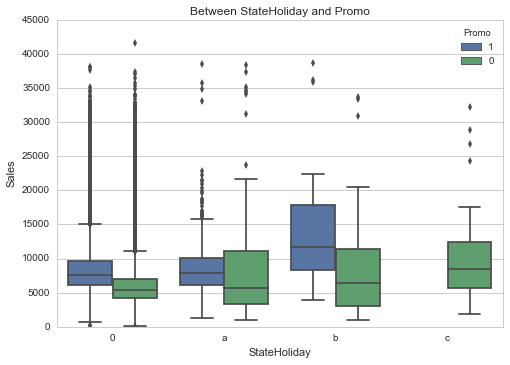

In [166]:
y = 'Sales'
ax = sns.boxplot(x = 'StateHoliday', y = 'Sales', hue = 'Promo', data = train_data)
ax.set_title("Between StateHoliday and Promo")

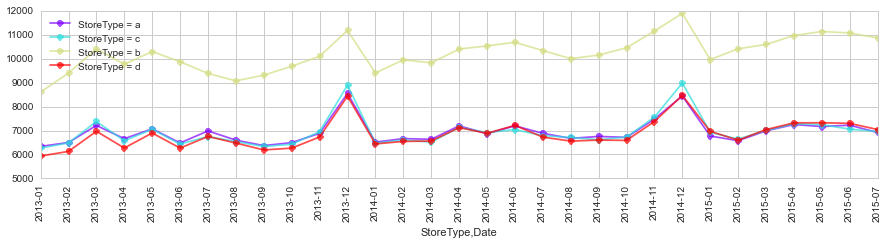

In [331]:
PlotAvgSalesByGroup('StoreType')

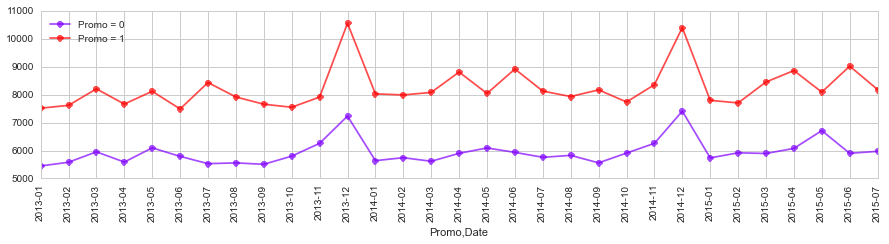

In [175]:
PlotAvgSalesByGroup('Promo')
# promo seems to interact with month a little 

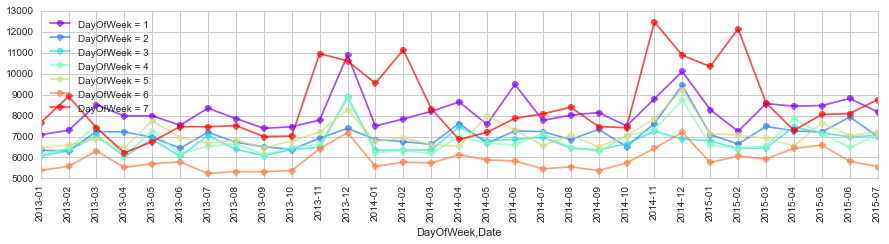

In [176]:
PlotAvgSalesByGroup('DayOfWeek')
# day of week interacts with month a lot

In [ ]:
# it looks like the christmas months are partcularly important and there is

#day7only 
#days1to6



BoxPlotGroupBy(train_data2, 'Sales', 'month', ax_list[0])

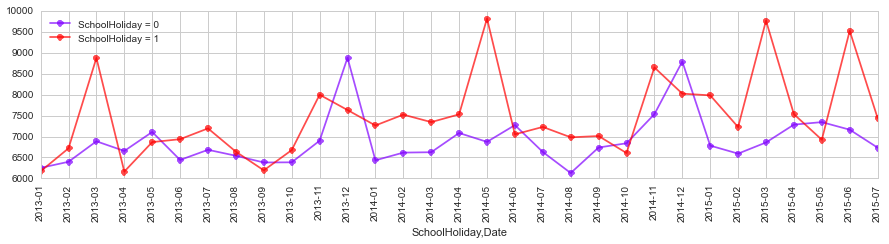

In [177]:
PlotAvgSalesByGroup('SchoolHoliday')
# school holiday is complex, but GENERALLY adds to sales 

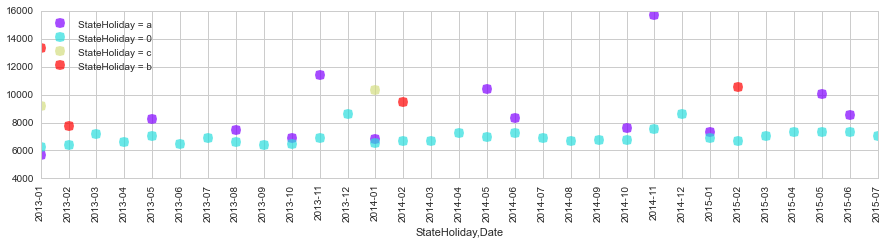

In [178]:
PlotAvgSalesByGroup('StateHoliday', linestyle='None', marker='o', markersize=10, alpha=0.7)

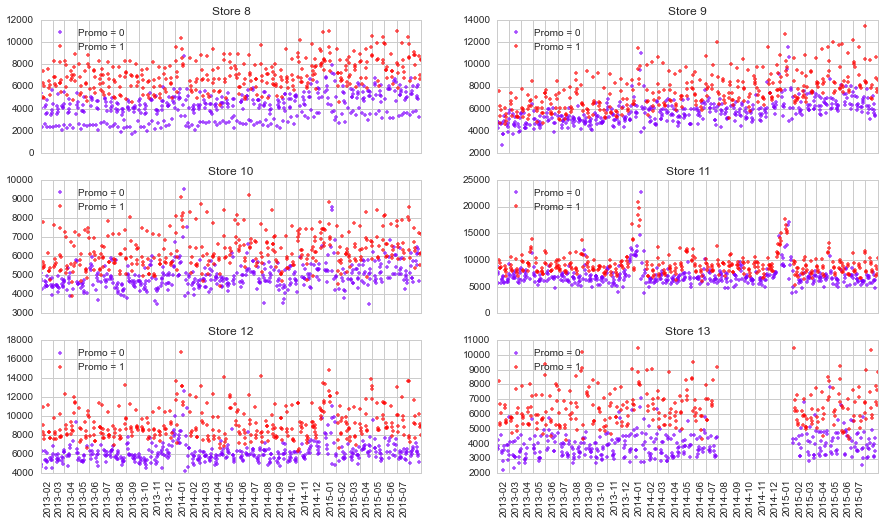

In [179]:
PlotAvgSalesByGroup('Promo', storeId=range(8,14), dim=[3,2], marker='.',daily=True, linestyle='None', alpha=0.7)

TypeError: There is no line property "Store"

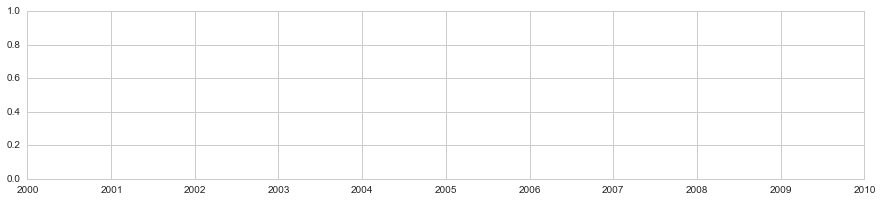

In [181]:
PlotAvgSalesByGroup('Promo', store=2, marker='.',daily=True, linestyle='None')

In [ ]:
PlotAvgSalesByGroup('StateHoliday', store=839, marker='.',daily=True, linestyle='None')

In [ ]:
PlotAvgSalesByGroup('SchoolHoliday', store=500, marker='.',daily=True, linestyle='None')

In [ ]:
PlotAvgSalesByGroup('Promo', store=13, marker='.',daily=True, linestyle='None')

In [99]:
# MERGE
#For each store, find its first opening day and merge it into store_df

#train_by_Store_data = train_data.groupby('Store')
#storeOpenDays = train_by_Store_data['Date'].min()
#pd.unique(storeOpenDays)
#storeOpenDays[storeOpenDays != np.datetime64('2013-01-02')]

#d = pd.DataFrame(storeOpenDays)
#d = d.rename(columns = {'Date':'OpenDay'})
#store_data = pd.merge(store_data, d, left_on = 'Store', right_index = True) 


In [ ]:
PlotAvgSalesByGroup('DayOfWeek', store=12, marker='.',daily=True, linestyle='None')

### Any relationship between Store Attributes and Average Monthly Sales?###
this is interesting since type b store is the least efficient at making sales, but has the most sales.

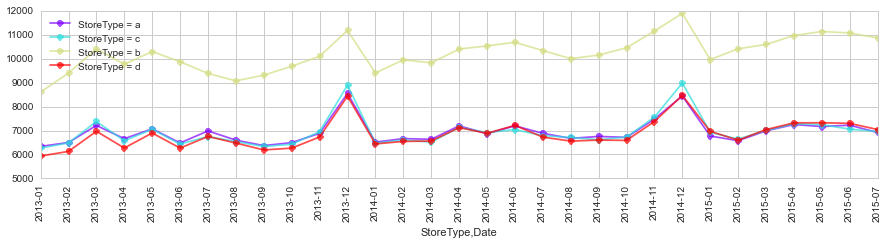

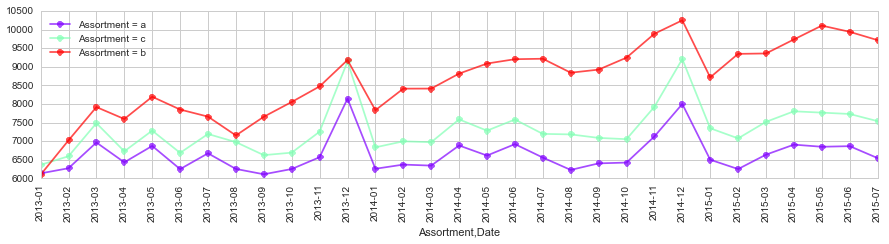

In [190]:
PlotAvgSalesByGroup('StoreType', alpha=0.7)
PlotAvgSalesByGroup('Assortment')
#PlotAvgSalesByGroup('StoreTypeAsst')

In [426]:
#I see a temporally increasing trend in store type b and assortment b somewhat assortment c (But not the others) have a
#how do we capture this variation, baseline increase for each class?

#regress assortment x date and use the correlation coefficient to get the temporal effect..
#change date to 1-days from opening 2-month (christmas season or not) 3-total days 

#subsetA=train_data2[train_data2==] 
train_data2.columns

Index([u'Store', u'DayOfWeek', u'Sales', u'Customers', u'Promo',
       u'StateHoliday', u'SchoolHoliday', u'month', u'StoreType_x',
       u'Assortment_x', u'CompetitionDistance_x',
       u'CompetitionOpenSinceMonth_x', u'CompetitionOpenSinceYear_x',
       u'Promo2_x', u'Promo2SinceWeek_x', u'Promo2SinceYear_x',
       u'PromoInterval_x', u'OpenDay_x', u'CompetitorOpenDay_x', u'CumlDays',
       u'SalePerCust', u'StoreType_y', u'Assortment_y', u'Slope',
       u'StoreTypeAsst', u'storeEff', u'MonthBin'],
      dtype='object')

KeyError: 'StoreType'

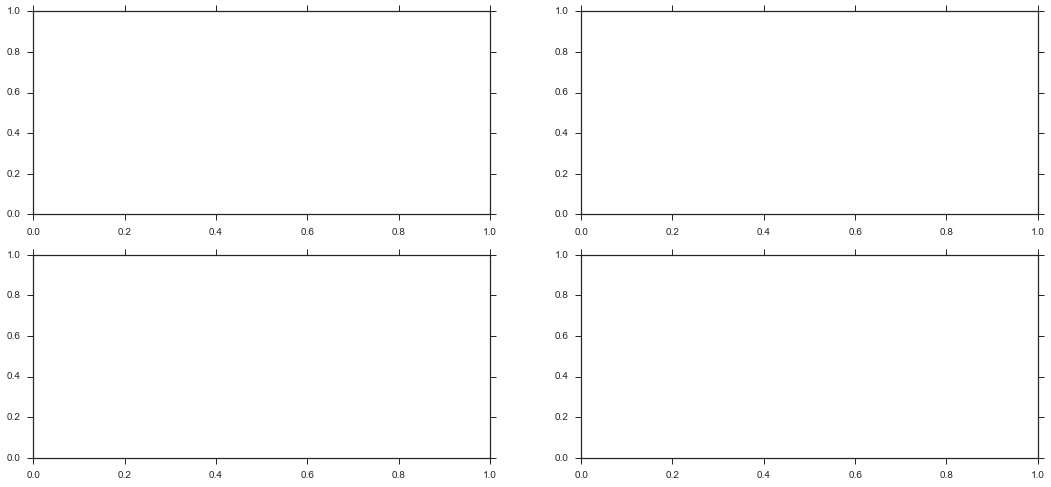

In [425]:
fig, ax_list = plt.subplots(2,2, figsize=(18,8))
ax_list = ax_list.ravel()

#BoxPlotGroupBy(store_data2,'Slope', 'Assortment', ax_list[0])
#BoxPlotGroupBy(store_data2,'Slope', 'StoreType', ax_list[1])
#BoxPlotGroupBy(store_data2,'Slope', 'StoreTypeAsst', ax_list[2])

BoxPlotGroupBy(train_data2, 'Sales', 'StoreType', ax_list[0])
BoxPlotGroupBy(train_data2, 'Customers', 'StoreType', ax_list[1])
BoxPlotGroupBy(train_data2, 'SalePerCust', 'StoreType', ax_list[2])
BoxPlotGroupBy(train_data2, 'SalePerCust', 'StoreTypeAsst', ax_list[3])
fig.tight_layout()

In [333]:
#how does customer map to stores and to store efficiency?

#mean customers per store 


#variation in customers per store
train_data2.columns

Index([u'Store', u'DayOfWeek', u'Sales', u'Customers', u'Promo',
       u'StateHoliday', u'SchoolHoliday', u'month', u'StoreType',
       u'Assortment', u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval', u'OpenDay', u'CompetitorOpenDay',
       u'CumlDays', u'SalePerCust'],
      dtype='object')

# 2 - Merge, Check, Summarize - Setup the data for analysis ##

In [34]:
#merge the store information
test_full_data = pd.merge(test_data, store_data.ix[:,['StoreType', 'Assortment', 'Store']], on='Store')
test_data_merge = transformData(test_full_data)
##result = makePredictions(test_data)

train_full_data = pd.merge(train_data, store_data.ix[:,['StoreType', 'Assortment', 'Store']], on='Store')
train_data_merge = transformData(train_full_data)

In [36]:
#Find factor levels in the trianing data
quantLevel(train_data, ['StateHoliday', 'SchoolHoliday', 'Promo'])

StateHoliday
0    0.998922
a    0.000822
b    0.000172
c    0.000084
dtype: float64

SchoolHoliday
0    0.806422
1    0.193578
dtype: float64

Promo
0    0.553644
1    0.446356
dtype: float64



In [37]:
test_data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 35092
Data columns (total 25 columns):
Id                 35093 non-null int64
Store              35093 non-null int64
Date               35093 non-null datetime64[ns]
DayOfWeek_1        35093 non-null float64
DayOfWeek_2        35093 non-null float64
DayOfWeek_3        35093 non-null float64
DayOfWeek_4        35093 non-null float64
DayOfWeek_5        35093 non-null float64
DayOfWeek_6        35093 non-null float64
DayOfWeek_7        35093 non-null float64
Promo_0            35093 non-null float64
Promo_1            35093 non-null float64
StateHoliday_0     35093 non-null float64
StateHoliday_a     35093 non-null float64
StateHoliday_b     35093 non-null float64
StateHoliday_c     35093 non-null float64
SchoolHoliday_0    35093 non-null float64
SchoolHoliday_1    35093 non-null float64
StoreType_a        35093 non-null float64
StoreType_b        35093 non-null float64
StoreType_c        35093 non-null float64
StoreT

In [38]:
train_data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 26 columns):
Store              844338 non-null int64
Date               844338 non-null datetime64[ns]
Sales              844338 non-null int64
Customers          844338 non-null int64
DayOfWeek_1        844338 non-null float64
DayOfWeek_2        844338 non-null float64
DayOfWeek_3        844338 non-null float64
DayOfWeek_4        844338 non-null float64
DayOfWeek_5        844338 non-null float64
DayOfWeek_6        844338 non-null float64
DayOfWeek_7        844338 non-null float64
Promo_0            844338 non-null float64
Promo_1            844338 non-null float64
StateHoliday_0     844338 non-null float64
StateHoliday_a     844338 non-null float64
StateHoliday_b     844338 non-null float64
StateHoliday_c     844338 non-null float64
SchoolHoliday_0    844338 non-null float64
SchoolHoliday_1    844338 non-null float64
StoreType_a        844338 non-null float64
StoreType_b        844338 no

In [39]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 95.8+ KB


In [48]:
train_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 11 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
StoreType        1017209 non-null object
Assortment       1017209 non-null object
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 93.1+ MB


In [40]:
test_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 35092
Data columns (total 9 columns):
Id               35093 non-null int64
Store            35093 non-null int64
DayOfWeek        35093 non-null int64
Date             35093 non-null datetime64[ns]
Promo            35093 non-null int64
StateHoliday     35093 non-null object
SchoolHoliday    35093 non-null int64
StoreType        35093 non-null object
Assortment       35093 non-null object
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 2.7+ MB


10.081855625605838

In [92]:
print len(sample_stores)
print dev_test_data.shape
print train_data.shape

111
(87672, 9)
(1017209, 9)


In [18]:
#SUBSET DEV AND TRAINING SET
#sample 20% of the train_data dataframe
sample_stores = random.sample(store_data.index, len(store_data)/20)
dev_train_data = train_data[train_data['Store'].isin(sample_stores)]

# Remove the mini_train data from the train dataframe
train_data = train_data[~train_data['Store'].isin(sample_stores)]

# use 10% for a dev_test data set
#>sample_stores = random.sample(store_data.index, len(store_data)/10)
#>dev_test_data = train_data[train_data['Store'].isin(sample_stores)]
#>train_data = train_data[~train_data['Store'].isin(sample_stores)]

In [ ]:
#Add new features inspired by patrick's exploratoy anaylsis

#total days 

#month

#attribute x total time 

#day of week x month 

#school holiday x month

#state holiday x promo



In [ ]:
#some other ideas 

# total time open

# customer X sales slope



    

In [ ]:
#scale the data

In [26]:
# lets see if test data contains closed stores too
# being closed is probably predictive of zero sales

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


In [397]:
print train_data2.columns
print test_data2.columns

# remove NaNs

train_data2.info()
test_data2.info()

Index([u'Store', u'DayOfWeek', u'Sales', u'Customers', u'Promo',
       u'StateHoliday', u'SchoolHoliday', u'month', u'StoreType',
       u'Assortment', u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval', u'OpenDay', u'CompetitorOpenDay',
       u'CumlDays', u'Slope', u'StoreTypeAsst', u'storeEff', u'SalePerCust'],
      dtype='object')
Index([u'Id', u'Store', u'DayOfWeek', u'Promo', u'StateHoliday',
       u'SchoolHoliday', u'month', u'StoreType', u'Assortment',
       u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval', u'OpenDay', u'CompetitorOpenDay',
       u'Slope', u'StoreTypeAsst', u'storeEff'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 24 columns):
Store                        

In [160]:
train_data2.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 27 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null object
SchoolHoliday                844338 non-null int64
month                        844338 non-null int64
StoreType                    844338 non-null object
Assortment                   844338 non-null object
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenSinceYear     844338 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              844338 non-null float64
Promo2SinceYear              844338 non-null float64
PromoInterval                844338 non-null object
OpenDay 

In [ ]:
test_data2.head()

# 3-show the models that we tried 
- i'll remove our names in the final book but lets keep it separate for clarity now
- Note that the modified dataframes are train_data2

In [327]:
### Setup, functions and packages ###

import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import operator
import matplotlib
matplotlib.use("Agg") #Needed to save figures
import matplotlib.pyplot as plt


 **3a-Ron's attemps**

** 3b-patrick's attemps **

** 3c-Gunnar's attemps** 

In [458]:
## functions ####

'''
Based on https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
which was based on
Based on https://www.kaggle.com/justdoit/rossmann-store-sales/xgboost-in-python-with-rmspe/code
Public Score :  0.11389
Private Validation Score :  0.096959
'''

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)


## Main script
## based on 

                                
# training the model script https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
def trainXGB(train, test, params, features, resultNm):
    start = time.time()
    num_boost_round = 300
    X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
    Y_train, Y_valid = np.log1p(X_train.Sales), np.log1p(X_valid.Sales) 
    dtrain = xgb.DMatrix(X_train[features], Y_train)
    dvalid = xgb.DMatrix(X_valid[features], Y_valid)

    #>watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
      early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True) #

    print("Validating")
    yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
    error = rmspe(X_valid.Sales.values, np.expm1(yhat))
    print('RMSPE: {:.6f}'.format(error))
    

    print("Make predictions on the test set")
    dtest = xgb.DMatrix(test[features])
    test_probs = gbm.predict(dtest)
    # Make Submission
    result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
    resultNm="xgboost_" + resultNm + "subm.csv"
    result.to_csv(resultNm, index=False)
    end = time.time()
    print 'the prediction took ' + str((end-start)/60) + 'Mins'
    
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
def feat_import(features, xgb):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    fig_featp = featp.get_figure()
    fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [424]:
#12_11_15 XGB

#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }


###  Scale ####
train_data2.fillna(0, inplace=True)
test_data2.fillna(0, inplace=True)

train_scaled = train_data2
test_scaled = test_data2
train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
preprocessing.scale(train_scaled['AdjDist'])
preprocessing.scale(test_scaled['AdjDist'])

trainXGB(train_scaled, test_scaled, params, features, 'x')


Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996852	eval-rmspe:0.996852
[1]	train-rmspe:0.981639	eval-rmspe:0.981646
[2]	train-rmspe:0.938308	eval-rmspe:0.938339
[3]	train-rmspe:0.857394	eval-rmspe:0.857320
[4]	train-rmspe:0.744900	eval-rmspe:0.744280
[5]	train-rmspe:0.620698	eval-rmspe:0.618136
[6]	train-rmspe:0.504969	eval-rmspe:0.498341
[7]	train-rmspe:0.413052	eval-rmspe:0.399831
[8]	train-rmspe:0.349137	eval-rmspe:0.327090
[9]	train-rmspe:0.310920	eval-rmspe:0.279160
[10]	train-rmspe:0.294194	eval-rmspe:0.253610
[11]	train-rmspe:0.288044	eval-rmspe:0.240878
[12]	train-rmspe:0.286578	eval-rmspe:0.235744
[13]	train-rmspe:0.281502	eval-rmspe:0.232359
[14]	train-rmspe:0.276603	eval-rmspe:0.227774
[15]	train-rmspe:0.277468	eval-rmspe:0.227384
[16]	train-rmspe:0.278333	eval-rmspe:0.227583
[17]	train-rmspe:0.276187	eval-rmspe:0.224801
[18]	train-rmspe:0.274262	eval-rmspe:0.224242
[19]	train-rmspe:0.271150	eval-rmspe:0.220265
[20]	train-rmspe:0.269909	eval

Validating
RMSPE: 0.153434
Make predictions on the test set


[299]	train-rmspe:0.208304	eval-rmspe:0.153434


TypeError: cannot concatenate 'str' and 'float' objects

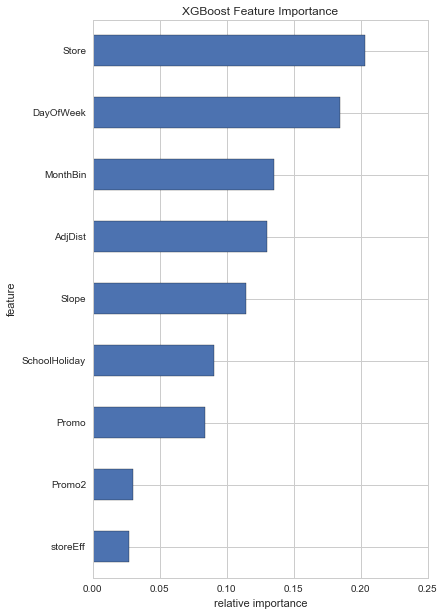

In [418]:
feat_import(features, xgb)

#RMSPE: 0.153434
# store (raw number) is the most important (.21)
# and store eff is the least (.025)
#slope seems to do pretty well (0.12)
# submitted, scored .13512

In [452]:
#12_11_15 2 XGB  # fixing adj distance so it is not 74,000-78000 
#and instead 0-5000 as it should be 

#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }

train_scaled = train_data2
train_scaled.fillna(0, inplace=True)
test_scaled = test_data2
test_scaled.fillna(0, inplace=True)


train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
preprocessing.scale(train_scaled['AdjDist'])
preprocessing.scale(test_scaled['AdjDist'])



trainXGB(train_scaled, test_scaled, params, features, 'x2')

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996764	eval-rmspe:0.996762
[1]	train-rmspe:0.980757	eval-rmspe:0.980775
[2]	train-rmspe:0.934968	eval-rmspe:0.935059
[3]	train-rmspe:0.848393	eval-rmspe:0.848466
[4]	train-rmspe:0.730652	eval-rmspe:0.730659
[5]	train-rmspe:0.605239	eval-rmspe:0.604376
[6]	train-rmspe:0.499607	eval-rmspe:0.496095
[7]	train-rmspe:0.428992	eval-rmspe:0.422309
[8]	train-rmspe:0.399459	eval-rmspe:0.387442
[9]	train-rmspe:0.398081	eval-rmspe:0.381808
[10]	train-rmspe:0.411444	eval-rmspe:0.391727
[11]	train-rmspe:0.428190	eval-rmspe:0.407250
[12]	train-rmspe:0.440425	eval-rmspe:0.418928
[13]	train-rmspe:0.453508	eval-rmspe:0.430733
[14]	train-rmspe:0.466625	eval-rmspe:0.444330
[15]	train-rmspe:0.471434	eval-rmspe:0.447541
[16]	train-rmspe:0.473172	eval-rmspe:0.448680
[17]	train-rmspe:0.472229	eval-rmspe:0.446996
[18]	train-rmspe:0.474361	eval-rmspe:0.449510
[19]	train-rmspe:0.472704	eval-rmspe:0.447700
[20]	train-rmspe:0.469628	eval

Validating
RMSPE: 0.155969
Make predictions on the test set


[109]	train-rmspe:0.439199	eval-rmspe:0.412158
Stopping. Best iteration:
[9]	train-rmspe:0.398081	eval-rmspe:0.381808



TypeError: cannot concatenate 'str' and 'float' objects

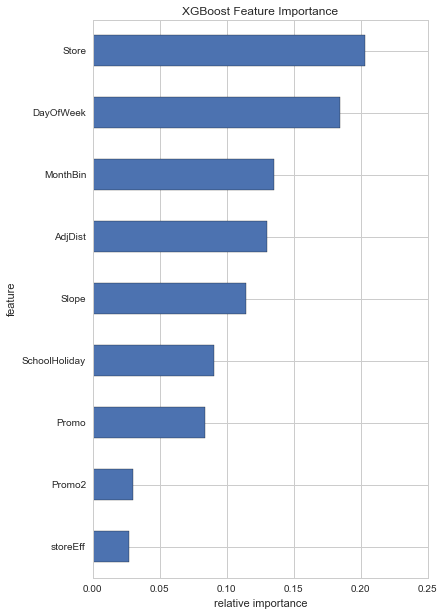

In [454]:
#with the 'corrected adj dist we do much worse.. 
#maybe competition was functioing as a dummy 0/1 variable

feat_import(features, xgb)

#RMSPE: 0.155969
#[9]	train-rmspe:0.398081	eval-rmspe:0.381808
# strange that hte graph looks the same and reported 
#RMSPE isvary diferent from train and eval versions        
# store (raw number) is the most important (.21)

# and store eff is the least (.025)
#slope seems to do pretty well (0.12)
# submitted, scored .13512

In [456]:
#12_11_15 3 XGB  # using raw adj distance without scaling


#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }

train_scaled = train_data2
train_scaled.fillna(0, inplace=True)
test_scaled = test_data2
test_scaled.fillna(0, inplace=True)


#train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
#test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
#preprocessing.scale(train_scaled['AdjDist'])
#preprocessing.scale(test_scaled['AdjDist'])



trainXGB(train_scaled, test_scaled, params, features, 'x3')

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996764	eval-rmspe:0.996762
[1]	train-rmspe:0.980757	eval-rmspe:0.980775
[2]	train-rmspe:0.934968	eval-rmspe:0.935059
[3]	train-rmspe:0.848393	eval-rmspe:0.848466
[4]	train-rmspe:0.730652	eval-rmspe:0.730659
[5]	train-rmspe:0.605239	eval-rmspe:0.604376
[6]	train-rmspe:0.499607	eval-rmspe:0.496095
[7]	train-rmspe:0.428992	eval-rmspe:0.422309
[8]	train-rmspe:0.399459	eval-rmspe:0.387442
[9]	train-rmspe:0.398081	eval-rmspe:0.381808
[10]	train-rmspe:0.411444	eval-rmspe:0.391727
[11]	train-rmspe:0.428190	eval-rmspe:0.407250
[12]	train-rmspe:0.440425	eval-rmspe:0.418928
[13]	train-rmspe:0.453508	eval-rmspe:0.430733
[14]	train-rmspe:0.466625	eval-rmspe:0.444330
[15]	train-rmspe:0.471434	eval-rmspe:0.447541
[16]	train-rmspe:0.473172	eval-rmspe:0.448680
[17]	train-rmspe:0.472229	eval-rmspe:0.446996
[18]	train-rmspe:0.474361	eval-rmspe:0.449510
[19]	train-rmspe:0.472704	eval-rmspe:0.447700
[20]	train-rmspe:0.469628	eval

Validating
RMSPE: 0.155969
Make predictions on the test set
the prediction took 1425738107.05 mins


[109]	train-rmspe:0.439199	eval-rmspe:0.412158
Stopping. Best iteration:
[9]	train-rmspe:0.398081	eval-rmspe:0.381808



In [457]:
# no improvemnt 

#RMSPE: 0.155969
#Make predictions on the test set
#the prediction took 1425738107.05 mins
#[109]	train-rmspe:0.439199	eval-rmspe:0.412158
#Stopping. Best iteration:
#[9]	train-rmspe:0.398081	eval-rmspe:0.381808

In [461]:
#12_11_15 4 XGB  # back to 74-78k Adj dist/ 78k

#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }

train_scaled = train_data2
train_scaled.fillna(0, inplace=True)
test_scaled = test_data2
test_scaled.fillna(0, inplace=True)


train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
preprocessing.scale(train_scaled['AdjDist'])
preprocessing.scale(test_scaled['AdjDist'])


trainXGB(train_scaled, test_scaled, params, features, 'x4')

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996839	eval-rmspe:0.996841
[1]	train-rmspe:0.981495	eval-rmspe:0.981507
[2]	train-rmspe:0.937684	eval-rmspe:0.937756
[3]	train-rmspe:0.855687	eval-rmspe:0.855651
[4]	train-rmspe:0.741590	eval-rmspe:0.740936
[5]	train-rmspe:0.616604	eval-rmspe:0.614241
[6]	train-rmspe:0.502017	eval-rmspe:0.495805
[7]	train-rmspe:0.413790	eval-rmspe:0.400683
[8]	train-rmspe:0.356339	eval-rmspe:0.335480
[9]	train-rmspe:0.330288	eval-rmspe:0.298510
[10]	train-rmspe:0.321087	eval-rmspe:0.282250
[11]	train-rmspe:0.323501	eval-rmspe:0.278184
[12]	train-rmspe:0.327266	eval-rmspe:0.278979
[13]	train-rmspe:0.330974	eval-rmspe:0.279479
[14]	train-rmspe:0.341681	eval-rmspe:0.284566
[15]	train-rmspe:0.338529	eval-rmspe:0.277152
[16]	train-rmspe:0.338236	eval-rmspe:0.275988
[17]	train-rmspe:0.342089	eval-rmspe:0.278513
[18]	train-rmspe:0.340416	eval-rmspe:0.275412
[19]	train-rmspe:0.336250	eval-rmspe:0.270597
[20]	train-rmspe:0.334671	eval

Validating
RMSPE: 0.153767
Make predictions on the test set
the prediction took 6.26577123404Mins


[299]	train-rmspe:0.282838	eval-rmspe:0.208909


In [ ]:
# yeah making adj dist values very high for close stores (almost binary ) gets the algorythm out of a rut

#RMSPE: 0.153767
#Make predictions on the test set
#the prediction took 6.26577123404Mins
#[299]	train-rmspe:0.282838	eval-rmspe:0.208909


In [469]:
# try adj dist threshold 10k instead of 5k
#12_11_15 5 XGB  # back to 74-78k Adj dist/ 78k

#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }

train_scaled = train_data2
train_scaled.fillna(0, inplace=True)
test_scaled = test_data2
test_scaled.fillna(0, inplace=True)


train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
preprocessing.scale(train_scaled['AdjDist'])
preprocessing.scale(test_scaled['AdjDist'])


trainXGB(train_scaled, test_scaled, params, features, 'x5')


Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996839	eval-rmspe:0.996841
[1]	train-rmspe:0.981495	eval-rmspe:0.981507
[2]	train-rmspe:0.937684	eval-rmspe:0.937756
[3]	train-rmspe:0.855687	eval-rmspe:0.855651
[4]	train-rmspe:0.741590	eval-rmspe:0.740936
[5]	train-rmspe:0.616604	eval-rmspe:0.614241
[6]	train-rmspe:0.502017	eval-rmspe:0.495805
[7]	train-rmspe:0.413790	eval-rmspe:0.400683
[8]	train-rmspe:0.356339	eval-rmspe:0.335480
[9]	train-rmspe:0.330288	eval-rmspe:0.298510
[10]	train-rmspe:0.321087	eval-rmspe:0.282250
[11]	train-rmspe:0.323501	eval-rmspe:0.278184
[12]	train-rmspe:0.327266	eval-rmspe:0.278979
[13]	train-rmspe:0.330974	eval-rmspe:0.279479
[14]	train-rmspe:0.341681	eval-rmspe:0.284566
[15]	train-rmspe:0.338529	eval-rmspe:0.277152
[16]	train-rmspe:0.338236	eval-rmspe:0.275988
[17]	train-rmspe:0.342089	eval-rmspe:0.278513
[18]	train-rmspe:0.340416	eval-rmspe:0.275412
[19]	train-rmspe:0.336250	eval-rmspe:0.270597
[20]	train-rmspe:0.334671	eval

Validating
RMSPE: 0.153767
Make predictions on the test set
the prediction took 6.52663220167Mins


[299]	train-rmspe:0.282838	eval-rmspe:0.208909


In [ ]:
## not better really
#RMSPE: 0.153767
#Make predictions on the test set
#the prediction took 6.52663220167Mins
#[299]	train-rmspe:0.282838	eval-rmspe:0.208909

In [473]:
#try using the old Adjustdist and 5k threshold

# try adj dist threshold 10k instead of 5k
#12_11_15 5 XGB  # back to 74-78k Adj dist/ 78k

#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }

train_scaled = train_data2
train_scaled.fillna(0, inplace=True)
test_scaled = test_data2
test_scaled.fillna(0, inplace=True)


train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
preprocessing.scale(train_scaled['AdjDist'])
preprocessing.scale(test_scaled['AdjDist'])


trainXGB(train_scaled, test_scaled, params, features, 'x6')



Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996839	eval-rmspe:0.996841
[1]	train-rmspe:0.981495	eval-rmspe:0.981507
[2]	train-rmspe:0.937684	eval-rmspe:0.937756
[3]	train-rmspe:0.855687	eval-rmspe:0.855651
[4]	train-rmspe:0.741590	eval-rmspe:0.740936
[5]	train-rmspe:0.616604	eval-rmspe:0.614241
[6]	train-rmspe:0.502017	eval-rmspe:0.495805
[7]	train-rmspe:0.413790	eval-rmspe:0.400683
[8]	train-rmspe:0.356339	eval-rmspe:0.335480
[9]	train-rmspe:0.330288	eval-rmspe:0.298510
[10]	train-rmspe:0.321087	eval-rmspe:0.282250
[11]	train-rmspe:0.323501	eval-rmspe:0.278184
[12]	train-rmspe:0.327266	eval-rmspe:0.278979
[13]	train-rmspe:0.330974	eval-rmspe:0.279479
[14]	train-rmspe:0.341681	eval-rmspe:0.284566
[15]	train-rmspe:0.338529	eval-rmspe:0.277152
[16]	train-rmspe:0.338236	eval-rmspe:0.275988
[17]	train-rmspe:0.342089	eval-rmspe:0.278513
[18]	train-rmspe:0.340416	eval-rmspe:0.275412
[19]	train-rmspe:0.336250	eval-rmspe:0.270597
[20]	train-rmspe:0.334671	eval

Validating
RMSPE: 0.153767
Make predictions on the test set
the prediction took 5.96785646677Mins


[299]	train-rmspe:0.282838	eval-rmspe:0.208909


**3d-Thomas' attemps**

**3e- Ensemble implementation**

**4-choose a final implementation **